In [1]:
!pip install jupyterthemes
!jt -t chesterish

# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.<br><br>
### **Зачем обрабатывать пропуски?**
* Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
* Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
* Большинство алгоритмов показывает лучшее качество на масштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.


## 1) Загрузка, импорт и первичный анализ данных
***
## Импорт библиотек
Импортируем библиотеки с помощью команды import. Будем подключать все библиотеки последовательно, по мере их использования.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

Используем данные из прошлой лабораторной работы, а именно vgsales.csv

In [3]:
data = pd.read_csv('database/vgsales.csv', sep = ",")

In [4]:
# размер набора данных
print(f'Строк - {data.shape[0]}\nСтолбцов - {data.shape[1]}')

Строк - 16598
Столбцов - 11


In [5]:
# типы колонок
data.dtypes

Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object

In [6]:
# проверим есть ли пропущенные значения
data.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             1
Publisher        59
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [7]:
# Первые 5 строк датасета
data.head(6)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,NaN,NaN,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26


## Обработка пропусков в данных
### Простые стратегии - удалениее или заполнение нулями
Удаление колонок, содержащих пустые значения `res = data.dropna(axis=1, how='any')`<br>
Удаление строк, содержащих пустые значения `res = data.dropna(axis=0, how='any')`<br><br>
*На всякий случай вот* [документация](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)<br><br>
**Удаление может производиться для группы строк или колонок.**

In [8]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((16598, 11), (16598, 8))

In [9]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((16598, 11), (16290, 11))

In [10]:
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,NaN,NaN,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [11]:
# В данном случае это некорректно, так как нулями заполняются в том числе категориальные колонки
data_new_3 = data.fillna(0)
data_new_3.head(6)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,0,0,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
5,6,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26


## "Внедрение значений" - импьютация (imputation)
### Обработка пропусков в числовых данных

In [12]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    #print(f'temp_null_count {temp_null_count}')
    dt = str(data[col].dtype)
    #print(f'dt {dt}')
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / data.shape[0]) * 100.0, 2)
        print(f'Колонка {col}. Тип данных {dt}. Количество пустых значений {temp_null_count}, {temp_perc}%.')

Колонка Year. Тип данных float64. Количество пустых значений 271, 1.63%.


In [13]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,Year
0,2006.0
1,1985.0
2,2008.0
3,2009.0
4,1996.0
...,...
16593,2002.0
16594,2003.0
16595,2008.0
16596,2010.0


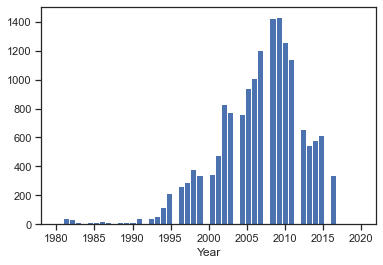

In [14]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

Будем использовать встроенные средства импьютации библиотеки scikit-learn - [ссылка](https://scikit-learn.org/stable/modules/impute.html)

In [15]:
data_num_MasVnrArea = data_num[['Year']]
data_num_MasVnrArea.head()

,Year
0,2006.0
1,1985.0
2,2008.0
3,2009.0
4,1996.0


In [16]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [17]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_MasVnrArea)
mask_missing_values_only

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

С помощью класса [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) можно проводить импьютацию различными [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)

In [18]:
strategies=['mean', 'median', 'most_frequent']

In [19]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_MasVnrArea)
    return data_num_imp[mask_missing_values_only]

In [20]:
strategies[0], test_num_impute(strategies[0])

('mean',
 array([2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2006.40644331, 2006.40644331,
        2006.40644331, 2006.40644331, 2

In [21]:
strategies[1], test_num_impute(strategies[1])

('median',
 array([2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007.,
        2007., 2007., 2007., 2007., 2007., 2007., 2007., 2007., 20

In [22]:
strategies[2], test_num_impute(strategies[2])

('most_frequent',
 array([2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009., 2009.,
        2009., 2009., 2009., 2009., 2009., 2009., 2009., 20

In [23]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    return column, strategy_param, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [24]:
data[['Year']].describe()

,Year
count,16327.000000
mean,2006.406443
std,5.828981
min,1980.000000
25%,2003.000000
50%,2007.000000
75%,2010.000000
max,2020.000000


In [25]:
test_num_impute_col(data, 'Year', strategies[0])

('Year', 'mean', 271, 2006.4064433147546, 2006.4064433147546)

In [26]:
test_num_impute_col(data, 'Year', strategies[1])

('Year', 'median', 271, 2007.0, 2007.0)

In [27]:
test_num_impute_col(data, 'Year', strategies[2])

('Year', 'most_frequent', 271, 2009.0, 2009.0)

### Обработка пропусков в категориальных данных

In [28]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / data.shape[0]) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Genre. Тип данных object. Количество пустых значений 1, 0.01%.
Колонка Publisher. Тип данных object. Количество пустых значений 59, 0.36%.


Класс SimpleImputer можно использовать для категориальных признаков со стратегиями "most_frequent" или "constant".

In [29]:
cat_temp_data = data[['Publisher']]
cat_temp_data.head()

,Publisher
0,Nintendo
1,Nintendo
2,NaN
3,Nintendo
4,Nintendo


In [30]:
# Будем выводить только первые 10, т.к там уникальных значений свыше 1000
cat_temp_data['Publisher'].unique()[0:10]

array(['Nintendo', nan, 'Microsoft Game Studios', 'Take-Two Interactive',
       'Sony Computer Entertainment', 'Activision', 'Ubisoft',
       'Bethesda Softworks', 'Electronic Arts', 'Sega'], dtype=object)

In [31]:
cat_temp_data[cat_temp_data['Publisher'].isnull()].shape

(59, 1)

In [32]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['Nintendo'],
       ['Nintendo'],
       ['Electronic Arts'],
       ...,
       ['Activision'],
       ['7G//AMES'],
       ['Wanadoo']], dtype=object)

In [33]:
# Будем выводить только первые 10, т.к там уникальных значений свыше 1000
# Пустые значения отсутствуют
np.unique(data_imp2)[0:10]

array(['10TACLE Studios', '1C Company', '20th Century Fox Video Games',
       '2D Boy', '3DO', '49Games', '505 Games', '5pb', '7G//AMES',
       '989 Sports'], dtype=object)

In [34]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['Nintendo'],
       ['Nintendo'],
       ['NA'],
       ...,
       ['Activision'],
       ['7G//AMES'],
       ['Wanadoo']], dtype=object)

In [35]:
# Будем выводить только первые 10, т.к там уникальных значений свыше 1000
np.unique(data_imp3)[0:10]

array(['10TACLE Studios', '1C Company', '20th Century Fox Video Games',
       '2D Boy', '3DO', '49Games', '505 Games', '5pb', '7G//AMES',
       '989 Sports'], dtype=object)

In [36]:
data_imp3[data_imp3=='NA'].size

59

## Преобразование категориальных признаков в числовые

In [37]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,Nintendo
1,Nintendo
2,Electronic Arts
3,Nintendo
4,Nintendo
...,...
16593,Kemco
16594,Infogrames
16595,Activision
16596,7G//AMES


### Кодирование категорий целочисленными значениями - [label encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [38]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [39]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [40]:
cat_enc['c1'].unique()[0:10]

array(['Nintendo', 'Electronic Arts', 'Microsoft Game Studios',
       'Take-Two Interactive', 'Sony Computer Entertainment',
       'Activision', 'Ubisoft', 'Bethesda Softworks', 'Sega',
       'SquareSoft'], dtype=object)

In [41]:
np.unique(cat_enc_le)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [42]:
le.inverse_transform([0, 1, 2, 3])

array(['10TACLE Studios', '1C Company', '20th Century Fox Video Games',
       '2D Boy'], dtype=object)

### Кодирование категорий наборами бинарных значений - [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [43]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [44]:
cat_enc.shape

(16598, 1)

In [45]:
cat_enc_ohe.shape

(16598, 578)

In [46]:
cat_enc_ohe

<16598x578 sparse matrix of type '<class 'numpy.float64'>'
	with 16598 stored elements in Compressed Sparse Row format>

In [47]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
cat_enc.head(10)

,c1
0,Nintendo
1,Nintendo
2,Electronic Arts
3,Nintendo
4,Nintendo
5,Nintendo
6,Nintendo
7,Nintendo
8,Nintendo
9,Nintendo


### [Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) - быстрый вариант one-hot кодирования

In [49]:
pd.get_dummies(cat_enc).head()

,c1_10TACLE Studios,c1_1C Company,c1_20th Century Fox Video Games,c1_2D Boy,c1_3DO,c1_49Games,c1_505 Games,c1_5pb,c1_7G//AMES,c1_989 Sports,...,c1_Zushi Games,c1_bitComposer Games,c1_dramatic create,c1_fonfun,c1_iWin,c1_id Software,c1_imageepoch Inc.,c1_inXile Entertainment,"c1_mixi, Inc",c1_responDESIGN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

,Publisher_10TACLE Studios,Publisher_1C Company,Publisher_20th Century Fox Video Games,Publisher_2D Boy,Publisher_3DO,Publisher_49Games,Publisher_505 Games,Publisher_5pb,Publisher_7G//AMES,Publisher_989 Sports,...,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN,Publisher_nan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Масштабирование данных<br>
Термины "масштабирование" и "нормализация" часто используются как синонимы. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины.

In [51]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

### [MinMax масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [52]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['Year']])

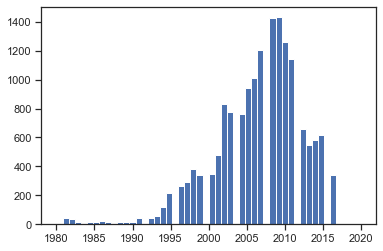

In [53]:
plt.hist(data['Year'], 50)
plt.show()

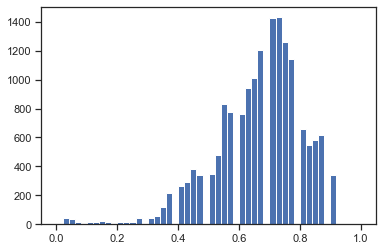

In [54]:
plt.hist(sc1_data, 50)
plt.show()

### Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0) - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

In [55]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['Year']])

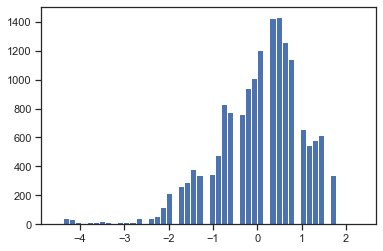

In [56]:
plt.hist(sc2_data, 50)
plt.show()